In [1]:
import re
import glob
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import scipy.stats as stats

In [2]:
def fasta_to_dataframe(seq):
    fasta_df = pd.read_csv(seq, sep='>', lineterminator='>', header=None)
    fasta_df[['tid','seq']]=fasta_df[0].str.split('\n', 1, expand=True)
    fasta_df['tid'] = fasta_df['tid']
    fasta_df['seq'] = fasta_df['seq'].replace('\n','', regex=True)
    fasta_df.drop(0, axis=1, inplace=True)
    fasta_df = fasta_df[fasta_df.seq != '']
    final_df = fasta_df.dropna()
    return final_df


def site_histories(df, sites, history, posterior, columns):
    """
    Parsing Malin's site histories output
    265 species
    history = loss, posterior = 0.99, columns = 530:795
    history = gain, posterior = 0.99, columns = 1051:1316
    history = present, posterior = 0.99, columns = 8:273
    """
    cols = columns.split(':')
    start = int(cols[0])
    end = int(cols[1])
    ls = df.iloc[:,start:end]
    for i in ls.columns:
        ls[i] = ls[i].astype(float)

    l = []
    for i in ls.columns:
        l.append(ls[ls[i]>float(posterior)])
    l = pd.concat(l)
    l = l.reset_index().rename(columns={'index':'site'})
    l = pd.merge(sites, l, on='site').drop_duplicates()

    ll = []
    for i in ls.columns:
        filt = l[['alignment','alipos',i]]
        filt = filt[filt[i]>float(posterior)]
        filt = pd.DataFrame(filt.groupby('alignment').alipos.agg(list)).reset_index()
        filt.columns = ['ortho','alipos']
        site = '-' + history
        filt['species'] = i.replace(site,'')
        ll.append(filt)
    ll = pd.concat(ll).reset_index(drop=True)
    ll['history'] = history
    return ll


def residue_position(seq):
    residues = list(re.finditer('[A-Z]+', seq))
    residue_pos = []
    for k,v in enumerate(residues):
        residue_pos.extend(list(range(v.start()*3, v.end()*3)))
    return residue_pos


def find_pos(i, j):
    if i[0]!=0:
        try:
            pos = i.index(j)
        except ValueError:
            pos = 'NaN'
    elif i[0]==0:
        pos = 0
    else:
        pos = 'NaN'
    return pos


def get_exons(pos):
    exons = []
    for i in range(len(pos)):
        if i < len(pos)-1:
            if pos[i] < pos[i+1]:
                exons.append([pos[i], pos[i+1]])
            elif pos[i] > pos[i+1]:
                print('Wrong CDS end position! ' + 
                      str(pos[i]) + ',' + str(pos[i+1]))
    return exons

In [3]:
# get intron positions
f = glob.glob('../intron_alignment_files/*.faaa')
df = []
for i in f:
    df.append(fasta_to_dataframe(i))

df = pd.concat(df).reset_index(drop=True)
df[['tid','ipos']] = df.tid.str.split(r'{i|i}',expand=True).drop([2],axis=1)
df[['species','tid','ortho']] = df['tid'].str.split(expand=True)[[1,0,3]]
df['species'] = df.species.str.replace('/organism=','')
df['ipos'] = df.ipos.str.replace(r'\s+','')\
.apply(lambda x: 0 if len(x)==0 else x)\
.str.split(',')\
.fillna({i: [0] for i in df.index})\
.apply(lambda x: [int(i) for i in x])

In [4]:
# get intron site histories
sites = pd.read_csv('../malin_input_files/intron_table_40129_48.txt',sep='\t', skiprows=266)[['site','alignment','alipos']]
# please download site_histories_40129_2L_1G.txt.gz from https://doi.org/10.5281/zenodo.4273072
h = pd.read_csv('site_histories_40129_2L_1G.txt.gz',sep='\t', skiprows=3)
stats = h[['site','prob0','prob1','present','ambiguous','lost','gained']]
h['prob0'] = h.prob0.astype(float)
h['prob1'] = h.prob1.astype(float)
sites = pd.merge(sites,stats,on='site')

# get intron site histories
ll = site_histories(h, sites, 'loss', '0.99', '530:795')
gg = site_histories(h, sites, 'gain', '0.99', '1051:1316')
pp = site_histories(h, sites, 'present', '0.99', '8:273')

In [ ]:
h = pd.concat([gg,ll,pp]).reset_index(drop=True)
dt = pd.merge(h,df,on=['species','ortho'])

# get all nt positions in alignment
dt['pos'] = dt.seq.apply(lambda x: residue_position(x))

# map alipos (ipos in alignment) to nt positions in alignment
dt = dt.explode('alipos').reset_index(drop=True)
dt['evolved_ipos'] = dt[['alipos','pos']].values.tolist()
dt['evolved_ipos'] = dt.evolved_ipos.apply(lambda x: find_pos(x[1],x[0]))

# compare annotated length and protein sequence length
# a = pd.read_csv('annotations.total.txt', sep='\t', comment='#', header=None, usecols=[1,5])
# a.columns = ['tid','annotated_length']
# a['annotated_length'] = (a.annotated_length*3).astype(int)
# dt = pd.merge(dt, a, on='tid')
# w = dt[~(dt.seq_length==dt.annotated_length) & ~(dt.seq_length-dt.annotated_length==3) & ~(dt.seq_length-dt.annotated_length==-3)]
# (w.seq_length-w.annotated_length).sort_values(ascending=False)
# dt[dt.seq_length-dt.annotated_length==-3].shape,dt[dt.seq_length-dt.annotated_length==3].shape

# get nth intron
dt['nth_intron'] = dt.evolved_ipos.apply(lambda x: [x]) + dt.ipos
dt['nth_intron'] = dt.nth_intron.apply(lambda x: np.unique(x).tolist())
dt['nth_intron'] = dt[['evolved_ipos','nth_intron']].values.tolist()
dt['nth_intron'] = dt.nth_intron.apply(lambda x: find_pos(x[1],x[0]) + 1)

# get intron counts
dt['intron_counts'] = dt.ipos.apply(lambda x: len(x) if x[0]!=0 else 0)

# get exon positions
dt['seq_length'] = dt.seq.apply(lambda x: len(x.replace('-',''))*3)
dt['epos'] = (pd.Series([0] * len(dt)).apply(lambda x: [x]) + 
              dt.seq_length.apply(lambda x: [x]) +
              dt.evolved_ipos.apply(lambda x: [x]) +
              dt.ipos).apply(lambda x: np.unique(x).tolist())
dt.drop(['alipos','seq','pos'], axis=1, inplace=True)
dt = dt[(dt.epos.apply(lambda x: len(x))!=2) & (dt.evolved_ipos!='NaN')]

# get all exons
dt['exons'] = dt.epos.apply(lambda x: get_exons(x))

# get intron loss/gain exons
dt['evolved_exons'] = dt[['nth_intron','epos']].values.tolist()
dt['evolved_exons'] = dt.evolved_exons.apply(lambda x: [x[1][x[0]-1], x[1][x[0]], x[1][x[0]+1]])
dt['evolved_ipos'] = dt.evolved_ipos.astype(int)
dt['seq_length'] = dt.seq_length.astype(int)
dt['check_ipos'] = dt[['ipos','evolved_ipos']].values.tolist()
dt['check_ipos'] = dt.check_ipos.apply(lambda x: [i for i in x[0] if i==x[1]])
dtl = dt[dt.history=='loss']
dtgp = dt[dt.astype(str)['check_ipos'] != '[]']
dt = pd.concat([dtl,dtgp])
dt = dt[(dt.evolved_ipos!=0) & (dt.evolved_ipos!=dt.seq_length)]
dt['check_ends'] = dt[['ipos','seq_length']].values.tolist()
dt = dt[(dt.check_ends.apply(lambda x: x[0][0]!=0)) & 
            (dt.check_ends.apply(lambda x: x[0][-1]!=x[1]))]
dt.to_pickle('evolved_exons.pkl')

In [3]:
# dt = pd.read_pickle('evolved_exons.pkl')

In [7]:
# get exon present
e = dt[dt.history=='present'][['tid','evolved_exons']]
e['Length (bp)'] = e.evolved_exons.apply(lambda x: [x[1]-x[0], x[2]-x[1]])
e['Exons'] = 'present'
e = e.explode('Length (bp)').drop_duplicates(['tid','Length (bp)'])[['tid','Length (bp)','Exons']]

In [8]:
# get representative exons from intron loss events
ele = pd.DataFrame(dt[dt.history=='loss'].groupby('tid').evolved_exons.agg(list)).reset_index()
ele['taxid'] = ele.tid.str.split('|').apply(lambda x: x[0])
ele['fused_exons'] = ele.evolved_exons.apply(lambda x: np.unique(list(itertools.chain.from_iterable(x))).tolist())
ele['fused_counts'] = ele.fused_exons.apply(lambda x: len(x))

# get 2-into-1 and 3-into-1 exons
p = ele[(ele.fused_counts==3) | (ele.fused_counts==4)].reset_index(drop=True)
p['length'] = p.fused_exons.apply(lambda x: x[-1] - x[0])
p = p[['tid','length','fused_counts']]

# get some other 2-into-1 exons
f = ele[(ele.fused_counts==5) & 
        (ele.evolved_exons.apply(lambda x: len(x)==2))].reset_index(drop=True)
f['length'] = f.evolved_exons.apply(lambda x: [x[0][-1] - x[0][0], x[1][-1] - x[1][0]])
f = f[['tid','length','fused_counts']].explode('length')

p = pd.concat([p,f])
p['fused_counts'] = p.fused_counts.astype(str).replace('3','2-into-1')\
.replace('4','3-into-1').replace('5','2-into-1')
p.columns = ['tid','Length (bp)','Exons']
p.drop_duplicates(['tid','Length (bp)'], inplace=True)

In [9]:
# get representative exons from intron gain events
se = pd.DataFrame(dt[dt.history=='gain'].groupby('tid').evolved_exons.agg(list)).reset_index()
se['taxid'] = se.tid.str.split('|').apply(lambda x: x[0])
se['split_exons'] = se.evolved_exons.apply(lambda x: np.unique(list(itertools.chain.from_iterable(x))).tolist())
se['split_counts'] = se.split_exons.apply(lambda x: len(x))

# get 1-into-2 and 1-into-3 exons
q = se[(se.split_counts==3) | (se.split_counts==4)].reset_index(drop=True)
q = q[['tid','split_exons','split_counts']]

In [10]:
# get some other 1-into-2 exons
s = se[(se.split_counts==5) & 
       (se.evolved_exons.apply(lambda x: len(x)==2))].reset_index(drop=True)
s = s.explode('evolved_exons')[['tid','evolved_exons']]
s['split_counts'] = 3
s.columns = ['tid','split_exons','split_counts']

# get exon lengths
q = pd.concat([q,s])
q['length'] = q.split_exons.apply(lambda x:
                                  [x[2]-x[1], x[1]-x[0]] if len(x)==3 else 
                                  [x[3]-x[2], x[2]-x[1], x[1]-x[0]])
q = q.explode('length')[['tid','length','split_counts']]

q['split_counts'] = q.split_counts.astype(str).replace('3','1-into-2').replace('4','1-into-3')
q.columns = ['tid','Length (bp)','Exons']
q.drop_duplicates(['tid','Length (bp)'], inplace=True)

In [11]:
# median lengths of different exon classes
e = pd.concat([p,q,e]).drop_duplicates(['tid','Length (bp)'])
e = e[e.Exons=='present']
dd = pd.concat([p,q,e])
dd['Length (bp)'] = dd['Length (bp)'].astype(int)

In [15]:
# summary of representative dataset
summary = dd.groupby('Exons').median().reset_index()
summary.columns = ['Exons','Median length (bp)']
total = pd.DataFrame(dd.Exons.value_counts()).reset_index()
total.columns = ['Exons','Counts']
pd.merge(summary,total,on='Exons')

,Exons,Median length (bp),Counts
0,1-into-2,235,4260
1,1-into-3,218,423
2,2-into-1,462,11950
3,3-into-1,1041,1265
4,present,172,378391


In [44]:
1041/172

6.0523255813953485

/Volumes/scratch/gardnerlab/cslim/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


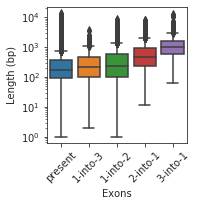

In [16]:
#sns.color_palette("tab10").as_hex()
plt.figure(figsize=(2.5,2.5))
sns.set_style("ticks")
g = sns.boxplot('Exons', 'Length (bp)', data=dd,
                order=['present','1-into-3','1-into-2','2-into-1','3-into-1']) #showfliers = False)
# g = sns.stripplot('fused_counts', 'length', data=p, 
#                   jitter=0.4, size=4, alpha=0.01, palette='tab10', linewidth=1)
g.set_yscale('log')
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.savefig('evolved_exons.pdf', bbox_inches='tight')

In [17]:
dd['log_length'] = np.log10(dd['Length (bp)'])

In [18]:
pg.pairwise_ttests(dv='log_length', between='Exons', tail='one-sided', padjust='bonf', data=dd)

/Volumes/scratch/gardnerlab/cslim/anaconda3/lib/python3.7/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,Exons,2-into-1,3-into-1,False,True,-31.409901,1709.098707,one-sided,1.218640e-171,1.218640e-170,bonf,1.041e+205,-0.777865
1,Exons,2-into-1,1-into-2,False,True,31.346866,6260.810466,one-sided,8.652186e-201,8.652186e-200,bonf,3.659e+205,0.624109
2,Exons,2-into-1,1-into-3,False,True,13.413368,442.536007,one-sided,5.780945e-35,5.780945e-34,bonf,3.673e+37,0.794212
3,Exons,2-into-1,present,False,True,103.303027,12857.170140,one-sided,0.000000e+00,0.000000e+00,bonf,inf,0.887367
4,Exons,3-into-1,1-into-2,False,True,48.300092,3284.378019,one-sided,0.000000e+00,0.000000e+00,bonf,inf,1.222505
5,Exons,3-into-1,1-into-3,False,True,24.785088,550.522022,one-sided,5.959457e-92,5.959457e-91,bonf,1.687e+112,1.696041
6,Exons,3-into-1,present,False,True,76.330734,1279.568664,one-sided,0.000000e+00,0.000000e+00,bonf,inf,1.589692
7,Exons,1-into-2,1-into-3,False,True,2.082414,517.278910,one-sided,1.889771e-02,1.889771e-01,bonf,0.979,0.102633
8,Exons,1-into-2,present,False,True,14.971502,4330.248612,one-sided,9.547066e-50,9.547066e-49,bonf,1.431e+47,0.267252
9,Exons,1-into-3,present,False,True,2.742695,422.758150,one-sided,3.176344e-03,3.176344e-02,bonf,4.541,0.148845


In [4]:
present = [len(dt[(dt.history=='present') & (dt.nth_intron==1)]),
           len(dt[(dt.history=='present') & (dt.nth_intron==2)]),
           len(dt[(dt.history=='present') & (dt.nth_intron==3)])]
loss = [len(dt[(dt.history=='loss') & (dt.nth_intron==1)]),
        len(dt[(dt.history=='loss') & (dt.nth_intron==2)]),
        len(dt[(dt.history=='loss') & (dt.nth_intron==3)])]
gain = [len(dt[(dt.history=='gain') & (dt.nth_intron==1)]),
        len(dt[(dt.history=='gain') & (dt.nth_intron==2)]),
        len(dt[(dt.history=='gain') & (dt.nth_intron==3)])]

In [5]:
np.array([present, loss]).T

array([[31070,  2052],
       [37662,  4744],
       [34417,  4026]])

In [6]:
obs = np.array([present, loss]).T
stats.chi2_contingency(obs)

(603.6904617939467,
 8.133581685283119e-132,
 2,
 array([[29976.9342903 ,  3145.0657097 ],
        [38379.38154443,  4026.61845557],
        [34792.68416527,  3650.31583473]]))

In [7]:
obs = np.array([gain, loss]).T
stats.chi2_contingency(obs)

(292.55671630981305,
 2.9656249818985092e-64,
 2,
 array([[ 383.33439111, 2326.66560889],
        [ 759.17183657, 4607.82816343],
        [ 640.49377231, 3887.50622769]]))

In [8]:
obs = np.array([gain, present]).T
stats.chi2_contingency(obs)

(42.157185313503504,
 7.009443232828576e-10,
 2,
 array([[  539.12080204, 31188.87919796],
        [  650.5370621 , 37634.4629379 ],
        [  593.34213586, 34325.65786414]]))

In [42]:
3*(7.009443232828576e-10)

2.102832969848573e-09

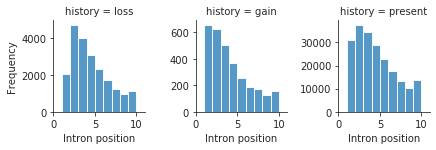

In [9]:
sns.set_style("ticks")
g = sns.FacetGrid(dt, col="history", sharey=False, height=2)
g.map_dataframe(sns.histplot, x="nth_intron", bins=range(0, 11, 1))
g.set(xlim=(0,11))
g.set_axis_labels("Intron position", "Frequency")
plt.savefig('nth_intron.pdf')

In [10]:
dt['nth_intron_rev'] = dt[['history','nth_intron','intron_counts']].values.tolist()
dt['nth_intron_rev'] = dt.nth_intron_rev.apply(lambda x: x[1]-x[2]-2 if x[0]=='loss' else x[1]-x[2]-1)
# loss = nth_intron-intron_counts-2
# gain = nth_intron-intron_counts-1
# gain = nth_intron-intron_counts-1

In [18]:
present = [len(dt[(dt.history=='present') & (dt.nth_intron_rev==-1)]),
           len(dt[(dt.history=='present') & (dt.nth_intron_rev==-2)]),
           len(dt[(dt.history=='present') & (dt.nth_intron_rev==-3)])]
loss = [len(dt[(dt.history=='loss') & (dt.nth_intron_rev==-1)]),
        len(dt[(dt.history=='loss') & (dt.nth_intron_rev==-2)]),
        len(dt[(dt.history=='loss') & (dt.nth_intron_rev==-3)])]
gain = [len(dt[(dt.history=='gain') & (dt.nth_intron_rev==-1)]),
        len(dt[(dt.history=='gain') & (dt.nth_intron_rev==-2)]),
        len(dt[(dt.history=='gain') & (dt.nth_intron_rev==-3)])]

In [20]:
obs = np.array([present, loss]).T
stats.chi2_contingency(obs)

(205.36349545691695,
 2.5461475606042678e-45,
 2,
 array([[51859.87969164,  6165.12030836],
        [42724.85461058,  5079.14538942],
        [31668.26569778,  3764.73430222]]))

In [40]:
3*(2.5461475606042678e-45)

7.638442681812804e-45

In [21]:
obs = np.array([gain, loss]).T
stats.chi2_contingency(obs)

(2.889100754460419,
 0.23585209719263195,
 2,
 array([[ 863.26309876, 6815.73690124],
        [ 642.47279716, 5072.52720284],
        [ 395.26410408, 3120.73589592]]))

In [22]:
obs = np.array([gain, present]).T
stats.chi2_contingency(obs)

(25.39837913330965,
 3.053599294192707e-06,
 2,
 array([[  772.74758494, 51321.25241506],
        [  642.4927275 , 42670.5072725 ],
        [  485.75968756, 32261.24031244]]))

In [41]:
3*(3.053599294192707e-06)

9.16079788257812e-06

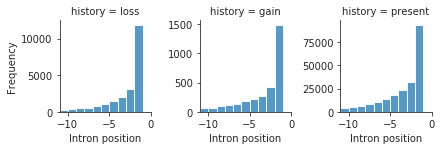

In [23]:
sns.set_style("ticks")
g = sns.FacetGrid(dt, col="history", sharey=False, height=2)
g.map_dataframe(sns.histplot, x="nth_intron_rev", bins=range(-11, 0, 1))
g.set(xlim=(-11,0))
g.set_axis_labels("Intron position", "Frequency")
plt.savefig('nth_intron_rev.pdf')

In [5]:
dt['evolved_ipos'] = dt.evolved_ipos.astype(int)
dt['dist_wrt_stop'] = dt.evolved_ipos - dt.seq_length
dt['norm_evolved_ipos'] = dt.evolved_ipos/dt.seq_length

In [ ]:
sns.set_style("ticks")
plt.figure(figsize=(2.5,2.5))
sns.kdeplot(x='norm_evolved_ipos', data=dt[dt.history=='present'], color='#1b9e77', 
            linestyle="--")
sns.kdeplot(x='norm_evolved_ipos', data=dt[dt.history=='gain'], color='#d95f02')
sns.kdeplot(x='norm_evolved_ipos', data=dt[dt.history=='loss'], color='#1f77b4')

sns.rugplot(x='norm_evolved_ipos', data=dt[dt.history=='loss'], color='#1f77b4', alpha=0.002)
sns.rugplot(x='norm_evolved_ipos', data=dt[dt.history=='gain'], color='#d95f02', alpha=0.002)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xlabel('')
plt.savefig('genebody.png', dpi=600)

In [29]:
stats.ks_2samp(dt[dt.history=='gain'].evolved_ipos.tolist(), 
               dt[dt.history=='loss'].evolved_ipos.tolist())

Ks_2sampResult(statistic=0.059267676923956986, pvalue=2.6114997496478215e-09)

In [30]:
stats.ks_2samp(dt[dt.history=='gain'].dist_wrt_stop.tolist(), 
               dt[dt.history=='loss'].dist_wrt_stop.tolist())

Ks_2sampResult(statistic=0.08233497144357849, pvalue=1.4308848313876544e-17)

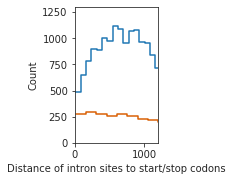

In [40]:
sns.set_style("ticks")
plt.figure(figsize=(1.5,2.5))
sns.histplot(x='evolved_ipos', data=dt[dt.history=='gain'], 
             color='#d95f02', fill=False, element="step", legend=True)
sns.histplot(x='evolved_ipos', data=dt[dt.history=='loss'], 
             color='#1f77b4', fill=False, element="step", legend=True)
plt.xlim(0, 1200)
plt.ylim(0, 1300)
plt.xlabel('Distance of intron sites to start/stop codons')
plt.savefig('wrt_start.pdf')

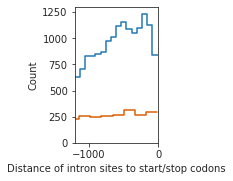

In [39]:
sns.set_style("ticks")
plt.figure(figsize=(1.5,2.5))
sns.histplot(x='dist_wrt_stop', data=dt[dt.history=='gain'], 
             color='#d95f02', fill=False, element="step", alpha=0.5)
sns.histplot(x='dist_wrt_stop', data=dt[dt.history=='loss'], 
             color='#1f77b4', fill=False, element="step", alpha=0.5)
plt.xlim(-1200, 0)
plt.ylim(0, 1300)
plt.xlabel('Distance of intron sites to start/stop codons')
plt.savefig('wrt_stop.pdf')